<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#imports" data-toc-modified-id="imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>imports</a></span></li><li><span><a href="#Moment-function-development" data-toc-modified-id="Moment-function-development-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Moment function development</a></span></li><li><span><a href="#Test-on-a-skew-normal-distribution" data-toc-modified-id="Test-on-a-skew-normal-distribution-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test on a skew normal distribution</a></span></li><li><span><a href="#spectrum-to-statistics" data-toc-modified-id="spectrum-to-statistics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>spectrum to statistics</a></span></li><li><span><a href="#SkewedGaussianModel-with-lmfit" data-toc-modified-id="SkewedGaussianModel-with-lmfit-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>SkewedGaussianModel with lmfit</a></span></li></ul></div>

# ```pySpectralMoments``` development

## Background

We want to develop an analysis function for extracting the moments of a spectrum, 

for source of the moments (definition) see:
https://doi.org/10.1016/S0926-2040(00)00063-1

$S(f)$ is the spectral function that describes our NMR spectrum.

The zeroth moment:

$M_0 = \int_{f_\mathrm{min}}^{f_\mathrm{max}} S(f)\,df$

is just the integral of the spectral function, the area under the spectrum.

The first moment:

$M_1 = \frac{1}{M_0}\int_{f_\mathrm{min}}^{f_\mathrm{max}}
f S(f)\,df$

is the isotropic shift of the spectrum, also called the center of gravity.

The second moment:

$M_2 = \frac{1}{M_0}\int_{f_\mathrm{min}}^{f_\mathrm{max}}
(f - M_1)^2 S(f)\,df$

is a measure of the linewidth of the spectrum.

The third moment:

$M_3 = \frac{1}{M_0}\int_{f_\mathrm{min}}^{f_\mathrm{max}}
(f - M_1)^3 S(f)\,df$

is a measure of the skewness of the spectrum

## imports

In [49]:
import numpy as np
from scipy import integrate
from scipy import stats
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

## Moment function development

In [2]:
x = np.arange(0, 10)
y = np.arange(0, 10)
integrate.simpson(y, x)

40.5

In [3]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.simpson.html#scipy.integrate.simpson
#scipy.integrate.simpson(y, x=None, dx=1, axis=- 1, even='avg') note, need version 1.6 for this function

def calc_spec_moments(S, 
                      f, 
                      f_min=None, 
                      f_max=None):
    """
    function to calculate the moments of an NMR frequency spectrum. 
    inputs are 1d numpy arrays for the spectral function S 
    and the frequency f. one can also choose integration limits via the f_min 
    and f_max variables. returns a tuple of the spectral moments 
    (M0 = area, 
     M1 = center of gravity,
     M2 = measure of width,
     M3 = measure of skewness)
    """
    # trim the arrays if we have given integration limits
    if (f_min is not None) and (f_max is not None):
        S = S[np.logical_and(f > f_min, f < f_max)]
        f = f[np.logical_and(f > f_min, f < f_max)]
        
    # calculate the moments via the simpson integration method
    M0 = integrate.simpson(y=S, x=f)
    M1 = integrate.simpson(y=S*f, x=f)/M0
    M2 = integrate.simpson(y=S*(f - M1)**2, x=f)/M0
    M3 = integrate.simpson(y=S*(f - M1)**3, x=f)/M0
    
    # also return useful parameters such as the linewidth and skewness
    sigma = (M2)**0.5
    skewness = M3/sigma**3
    
    return (M0, M1, M2, M3, sigma, skewness)

In [45]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.trapezoid.html#scipy.integrate.trapezoid
# scipy.integrate.trapezoid(y, x=None, dx=1.0, axis=- 1)

def calc_spec_moments_trap(S, 
                           f, 
                           f_min=None, 
                           f_max=None):
    """
    function to calculate the moments of an NMR frequency spectrum. 
    inputs are 1d numpy arrays for the spectral function S 
    and the frequency f. one can also choose integration limits via the f_min 
    and f_max variables. returns a tuple of the spectral moments 
    (M0 = area, 
     M1 = center of gravity,
     M2 = measure of width,
     M3 = measure of skewness)
    """
    # trim the arrays if we have given integration limits
    if (f_min is not None) and (f_max is not None):
        S = S[np.logical_and(f > f_min, f < f_max)]
        f = f[np.logical_and(f > f_min, f < f_max)]
        
    # calculate the moments via the simpson integration method
    M0 = integrate.trapezoid(y=S, x=f)
    M1 = integrate.trapezoid(y=S*f, x=f)/M0
    M2 = integrate.trapezoid(y=S*(f - M1)**2, x=f)/M0
    M3 = integrate.trapezoid(y=S*(f - M1)**3, x=f)/M0
    
    # also return useful parameters such as the linewidth and skewness
    sigma = (M2)**0.5
    skewness = M3/sigma**3
    
    return (M0, M1, M2, M3, sigma, skewness)

In [4]:
# @ 23.95 T in https://doi.org/10.1103/PhysRevLett.106.057003 
0.04500512870610074

0.04500512870610074

In [46]:
exp_data = np.genfromtxt(fname='25T_spectrum_Mounce.txt', 
                         delimiter=' ', 
                         skip_header=1, 
                         missing_values='nan')
exp_x = exp_data[:, 0]
exp_y = exp_data[:, 1]

In [47]:
calc_spec_moments(S=exp_y, f=exp_x)

(0.017720474479399312,
 0.014957253054012513,
 0.0032615467296504197,
 7.06832308701622e-05,
 0.0571099529823867,
 0.37947309083181313)

the above is not exactly the same, in terms of linewidth, but close in magnitude, lets do some more careful tests below based on real functions

In [7]:
## Test on a normal distribution

In [48]:
def gaussian(x, mu, sigma):
    return np.exp(-(x - mu)**2/(2*sigma**2))

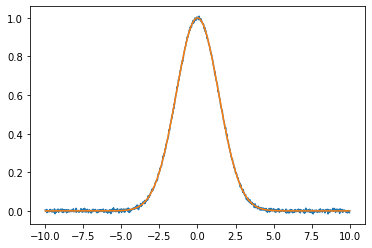

In [107]:
x = np.linspace(-10, 10, 1000)
gauss = gaussian(x=x_test_data,
                   mu=0.0,
                   sigma=1.4)

# add some gaussian noise
noise = np.random.normal(0, 0.005, 1000)
noisy_gauss = gauss + noise
plt.plot(x, noisy_gauss)
plt.plot(x, gauss)
plt.show()

In [108]:
calc_spec_moments(S=gauss, f=x)

(3.5092795844801925, 0.0, 1.9599999999068656, 0.0, 1.3999999999667376, 0.0)

In [109]:
calc_spec_moments(S=noisy_gauss, f=x)

(3.508069548241054,
 -0.0017958649647494209,
 1.9806970686134528,
 -0.10916497541690488,
 1.4073723986967532,
 -0.03916122180531203)

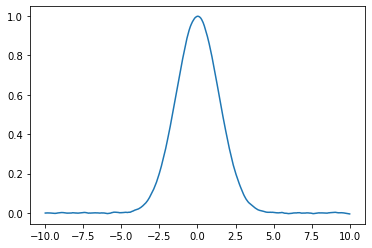

In [110]:
noisy_gauss_filt = savgol_filter(x=noisy_gauss, 
                                 window_length=57, 
                                 polyorder=4)
#plt.plot(x, noisy_gauss)
#plt.plot(x, gauss)
plt.plot(x, noisy_gauss_filt)
plt.show()

In [111]:
calc_spec_moments(S=noisy_gauss_filt, f=x)

(3.5080916832097038,
 -0.00165025310564274,
 1.981615722572943,
 -0.09658625128410667,
 1.4076987328874537,
 -0.0346247105419245)

In [112]:
calc_spec_moments(S=noisy_gauss_filt, 
                  f=x, 
                  f_min=-5, 
                  f_max=5)

(3.505073754104779,
 0.0016425635636863672,
 1.943949828609243,
 0.01057149874231647,
 1.394256012577763,
 0.003900398532941851)

## Test on a skew normal distribution

https://en.wikipedia.org/wiki/Skew_normal_distribution

\begin{equation}
\frac{2}{\omega\sqrt{2\pi}}e^{-\frac{(x - \xi)^2}{2\omega^2}} \int_{-\infty}^{\alpha\left( \frac{x-\xi}{\omega} \right)} \frac{1}{\sqrt{2\pi}} e^{-\frac{t^2}{2}}\,dt
\end{equation}

where $\xi$ is the location, $\omega$ is the scale, and $\alpha$ is the shape.

The skewness is:

\begin{equation}
\gamma_1 = \frac{4-\pi}{2} \frac{(\delta\sqrt{2/\pi})^3}{(1 - 2\delta^2/\pi)^{3/2}}
\end{equation}

with 

\begin{equation}
\delta = \frac{\alpha}{\sqrt{1+\alpha^2}} 
\end{equation}

In [10]:
a = 3
mean, var, skew, kurt = skewnorm.stats(a, moments='mvsk')
mean, var, skew

(array(0.75693976), array(0.4270422), array(0.66702357))

In [11]:
delta = a/(1+a**2)**0.5
(4-np.pi)*(delta*(2/np.pi)**0.5)**3/(2*(1-2*delta**2/np.pi)**1.5)

0.6670235701524079

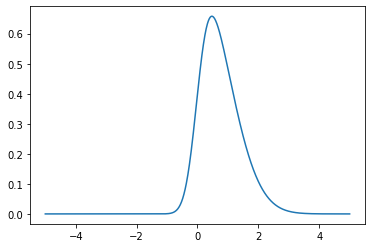

In [12]:
x = np.linspace(-5, 5, 1000)
skew_norm = skewnorm.pdf(x, a)
plt.plot(x, skew_norm)
plt.show()

In [43]:
calc_spec_moments(S=skew_norm, f=x)

(0.9999994266998893,
 0.7569372171330984,
 0.42703118217542646,
 0.18609656459461346,
 0.6534762292351777,
 0.666881965410274)

In [14]:
var**0.5

0.6534846630711212

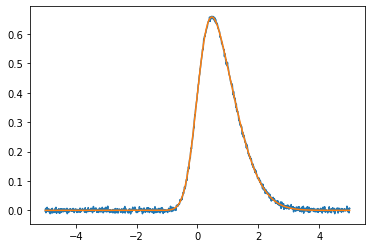

In [39]:
noise = np.random.normal(0, 0.005, 1000)
skew_norm_noise = skew_norm + noise

plt.plot(x, skew_norm_noise)
plt.plot(x, skew_norm)
plt.show()

In [40]:
calc_spec_moments(S=skew_norm_noise, f=x)

(1.0001516824009342,
 0.7649537220357159,
 0.4344477956082286,
 0.2692602790889251,
 0.6591265399058276,
 0.9402988277378341)

In [41]:
calc_spec_moments_trap(S=skew_norm_noise, f=x)

(1.0001428997214985,
 0.7649878914057967,
 0.43418609859725865,
 0.27045882440538727,
 0.6589279919666933,
 0.9453383669354579)

## spectrum to statistics

great! so we are getting the skewness properly now lets try one more thing, basically ignoring the integration method, and intead reverse engineering a raw 1D data set of frequencies, based on the "histogram" that is our spectrum. then we can perform statistics on that data, perhaps this will not work, but its worth a shot, as clearly it is known that the integration methods are very noise-sensitive.

This idea was not a good one... proceed with fitting to a skewed gaussian model below, which will be much better and able to characterize the uncertainty properly using lmfit

-0.012056073893963435

In [120]:
skew_norm_noise_pos = skew_norm_noise + abs(skew_norm_noise.min())


0.0

In [141]:
import scipy.stats

import numpy as np

data = scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5, random_state=123)

hist = np.histogram(data, bins=100)

hist_dist = scipy.stats.rv_histogram(hist)

In [140]:
print(hist_dist.moment(3))

0.11175242169845606


## SkewedGaussianModel with lmfit

working with data from:
    Z:\Ulrich\Processed Measurement Data 07-09_20\FePS_data_ab_07_2020\09_20_out_of_plane_vol_2\2020-09-01-outofplane_goni_290K

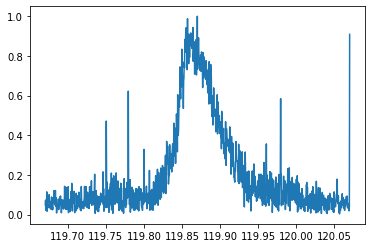

In [12]:
# import the data
data = np.genfromtxt(fname='07_835_119870_MHz_echoFFT_apd.txt', 
                         delimiter='\t', 
                         skip_header=1, 
                         missing_values='nan')
x = data[:, 0]
y = data[:, 1]

plt.plot(x, y)
plt.show()


In [15]:
from lmfit.models import GaussianModel
from lmfit.models import SkewedGaussianModel
from lmfit.models import ConstantModel

[[Model]]
    (Model(gaussian) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 1024
    # variables        = 4
    chi-square         = 5.72481486
    reduced chi-square = 0.00561256
    Akaike info crit   = -5303.14147
    Bayesian info crit = -5283.41559
[[Variables]]
    c:          0.08657906 +/- 0.00285402 (3.30%) (init = 0.1041015)
    amplitude:  0.04582040 +/- 6.5292e-04 (1.42%) (init = 0.4346177)
    center:     119.870442 +/- 3.3212e-04 (0.00%) (init = 119.8715)
    sigma:      0.02460587 +/- 3.5801e-04 (1.45%) (init = 0.1453125)
    fwhm:       0.05794239 +/- 8.4305e-04 (1.45%) == '2.3548200*sigma'
    height:     0.74289978 +/- 0.00891518 (1.20%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.653
    C(c, amplitude)     = -0.572
    C(c, sigma)         = -0.373


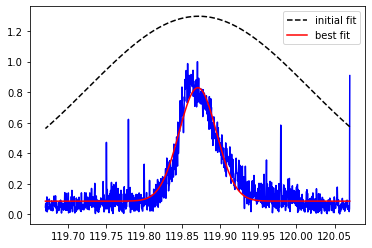

In [21]:
peak = GaussianModel()
offset = ConstantModel()
model = peak + offset

pars = offset.make_params(c=np.median(y))
pars += peak.guess(y, x=x)
out = model.fit(y, pars, x=x)

print(out.fit_report())

plt.plot(x, y, 'b')
plt.plot(x, out.init_fit, 'k--', label='initial fit')
plt.plot(x, out.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

[[Model]]
    (Model(skewed_gaussian) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 112
    # data points      = 1024
    # variables        = 5
    chi-square         = 4.52108375
    reduced chi-square = 0.00443678
    Akaike info crit   = -5542.86536
    Bayesian info crit = -5518.20800
[[Variables]]
    c:          0.08331306 +/- 0.00257044 (3.09%) (init = 0.1041015)
    amplitude:  0.04712680 +/- 6.0324e-04 (1.28%) (init = 0.4346177)
    center:     119.844737 +/- 4.2069e-04 (0.00%) (init = 119.8715)
    sigma:      0.04140077 +/- 7.5276e-04 (1.82%) (init = 0.1453125)
    gamma:      3.31153355 +/- 0.19318160 (5.83%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.756
    C(sigma, gamma)      =  0.682
    C(center, gamma)     = -0.607
    C(c, amplitude)      = -0.587
    C(amplitude, sigma)  =  0.535
    C(amplitude, center) = -0.353
    C(c, sigma)          = -0.314
    C(c, center)

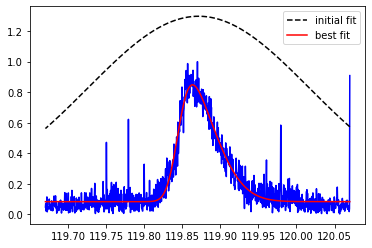

In [22]:
peak = SkewedGaussianModel()
offset = ConstantModel()
model = peak + offset

pars = offset.make_params(c=np.median(y))
pars += peak.guess(y, x=x)
out = model.fit(y, pars, x=x)

print(out.fit_report())

plt.plot(x, y, 'b')
plt.plot(x, out.init_fit, 'k--', label='initial fit')
plt.plot(x, out.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

but what is gamma?? It turns out to be alpha from the wikipedia page:
    https://en.wikipedia.org/wiki/Skew_normal_distribution
    
this was confusing, because that same wiki page also defined it as

In [31]:
from scipy.special import erf
from numpy import pi, sqrt, exp
s2pi = sqrt(2*pi)
s2 = sqrt(2.0)
tiny = 1.0e-15

def gaussian(x, amplitude=1.0, center=0.0, sigma=1.0):
    """Return a 1-dimensional Gaussian function.
    gaussian(x, amplitude, center, sigma) =
        (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))
    """
    return ((amplitude/(max(tiny, s2pi*sigma)))
            * exp(-(1.0*x-center)**2 / max(tiny, (2*sigma**2))))

def skewed_gaussian(x, amplitude=1.0, center=0.0, sigma=1.0, gamma=0.0):
    """Return a Gaussian lineshape, skewed with error function.
    Equal to: gaussian(x, center, sigma)*(1+erf(beta*(x-center)))
    where ``beta = gamma/(sigma*sqrt(2))``
    with ``gamma < 0``: tail to low value of centroid
         ``gamma > 0``: tail to high value of centroid
    For more information, see:
    https://en.wikipedia.org/wiki/Skew_normal_distribution
    """
    asym = 1 + erf(gamma*(x-center)/max(tiny, (s2*sigma)))
    return asym * gaussian(x, amplitude, center, sigma)

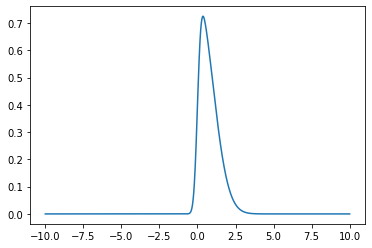

In [87]:
x = np.linspace(-10,10,1000)
sg = skewed_gaussian(x, amplitude=1.0, center=0.0, sigma=1.0, gamma=5.2)
plt.plot(x, sg)
plt.show()

In [91]:
import random
dist = np.array(random.choices(x,weights=sg,k=int(4e6)))
stats.skew(dist)

0.8614457386143608

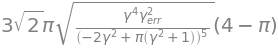

In [108]:
# calculated the uncertatinty in the skewness based on the uncertainty in gamma
import sympy as sp

gamma, gamma_err = sp.symbols('gamma gamma_err')

# the following come from the above cited wikipedia page
delta = gamma/(1+gamma**2)**sp.Rational(1, 2)
skewness = (4-sp.pi)*(delta*(2/sp.pi)**sp.Rational(1, 2))**3/(2*((1-2*delta**2/sp.pi))**sp.Rational(3, 2))

# so the uncertainty in in the skewness, based on gamma and the uncertainty in gamma, is given by
sp.simplify(sp.sqrt(sp.diff(skewness, gamma)**2*gamma_err**2))

In [109]:
def calc_skewness(gamma, gamma_err=None):
    delta = gamma/(1+gamma**2)**0.5
    skewness = (4-np.pi)*(delta*(2/np.pi)**0.5)**3/(2*((1-2*delta**2/np.pi))**1.5)
    if gamma_err is None:
        skewness_err = None
    else:
        skewness_err = 3*sqrt(2)*pi*sqrt(gamma**4*gamma_err**2/(-2*gamma**2 + pi*(gamma**2 + 1))**5)*(4 - pi)

    return (skewness, skewness_err)

In [112]:
skew, skew_err = calc_skewness(gamma=3.31153355, gamma_err=0.19318160)
print(skew, skew_err)

0.7113507569908649 0.0249737325078402
